import pandas as pd
import numpy as np
from sklearn import *
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()
(market_train, news_train) = env.get_training_data()

def data_prep(market_train,news_train):
    market_train.time = market_train.time.dt.date
    news_train.time = news_train.time.dt.hour
    news_train.sourceTimestamp= news_train.sourceTimestamp.dt.hour
    news_train.firstCreated = news_train.firstCreated.dt.date
    news_train['assetCodesLen'] = news_train['assetCodes'].map(lambda x: len(eval(x)))
    news_train['assetCodes'] = news_train['assetCodes'].map(lambda x: list(eval(x))[0])
    kcol = ['firstCreated', 'assetCodes']
    news_train = news_train.groupby(kcol, as_index=False).mean()
    market_train = pd.merge(market_train, news_train, how='left', left_on=['time', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])
    lbl = {k: v for v, k in enumerate(market_train['assetCode'].unique())}
    market_train['assetCodeT'] = market_train['assetCode'].map(lbl)
    
    
    market_train = market_train.dropna(axis=0)
    
    return market_train

market_train = data_prep(market_train,news_train)

# The target is binary
up = market_train.returnsOpenNextMktres10 >= 0

fcol = [c for c in market_train if c not in ['assetCode', 'assetCodes', 'assetCodesLen', 'assetName', 'audiences', 
                                             'firstCreated', 'headline', 'headlineTag', 'marketCommentary', 'provider', 
                                             'returnsOpenNextMktres10', 'sourceId', 'subjects', 'time', 'time_x', 'universe','sourceTimestamp']]

# We still need the returns for model tuning
X = market_train[fcol].values
up = up.values
r = market_train.returnsOpenNextMktres10.values

# Scaling of X values
# It is good to keep these scaling values for later
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

# Sanity check
assert X.shape[0] == up.shape[0] == r.shape[0]

X_train, X_test, up_train, up_test, r_train, r_test\
= model_selection.train_test_split(X, up, r, test_size=0.25, random_state=99)

from xgboost import XGBClassifier
import time

xgb_up = XGBClassifier(n_jobs=4,n_estimators=200,max_depth=8,eta=0.1)


t = time.time()
print('Fitting Up')
xgb_up.fit(X_train,up_train)
print(f'Done, time = {time.time() - t}')

A side effect of treating this as a binary task is that we can use a simpler metric to judge our models

from sklearn.metrics import accuracy_score
accuracy_score(xgb_up.predict(X_test),up_test)

days = env.get_prediction_days()

n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    print(n_days,end=' ')
    t = time.time()
    market_obs_df = data_prep(market_obs_df, news_obs_df)
    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(predictions_template_df.assetCode)]
    X_live = market_obs_df[fcol].values
    X_live = 1 - ((maxs - X_live) / rng)
    prep_time += time.time() - t
    
    t = time.time()
    lp = xgb_up.predict_proba(X_live)
    prediction_time += time.time() -t
    
    t = time.time()
    confidence = 2* lp[:,1] -1
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t

env.write_submission_file()

total = prep_time + prediction_time + packaging_time
print(f'Preparing Data: {prep_time:.2f}s')
print(f'Making Predictions: {prediction_time:.2f}s')
print(f'Packing: {packaging_time:.2f}s')
print(f'Total: {total:.2f}s')

For good measure, we can check what XGBoost bases its decisions on

import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import plot_importance

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(range(len(xgb_up.feature_importances_)), xgb_up.feature_importances_)
plt.xticks(range(len(xgb_up.feature_importances_)), fcol, rotation='vertical');

# Second Analysis

## Introduction
In this competition you will predict how stocks will change based on the market state and news articles. You will loop through a long series of trading days; for each day, you'll receive an updated state of the market, and a series of news articles which were published since the last trading day, along with impacted stocks and sentiment analysis. You'll use this information to predict whether each stock will have increased or decreased ten trading days into the future. Once you make these predictions, you can move on to the next trading day.

## TL;DR: End-to-End Usage Example

In [1]:
## Libraris
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2)

import warnings 
warnings.filterwarnings('ignore')
import os

In the data file description, About this file This is just a sample of the market data. You should not use this data directly.
Instead, call env.get_training_data() from the twosigmanews package to get the full training sets in your Kernel.

So you download directly below. I am using DJ sterling kernel(https://www.kaggle.com/dster/two-sigma-news-official-getting-started-kernel) thnaks

In [2]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()
print('Done!')

Loading the data... This could take a minute.
Done!


### Load train_data

In [3]:
(market_train_df, news_train_df) = env.get_training_data()
display("In total: ", market_train_df.shape)

'In total: '

(4072956, 16)

In [4]:
market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


In [5]:
display("In total: ", news_train_df.shape)

'In total: '

(9328750, 35)

In [6]:
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'Z', 'O', 'OIL'}",1438,1,,False,11,275,"{'0857.HK', '0857.F', '0857.DE', 'PTR.N'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.DE', 'WMT.N'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.149071,-1,0.699274,0.209360,0.091366,102,0,0,0,0,0,0,0,0,0,0


### Load test_data

In [7]:
days = env.get_prediction_days()
(market_obs_df, news_obs_df, predictions_template_df) = next(days)

In [8]:
print("Total: ", market_obs_df.shape)

Total:  (1823, 14)


In [9]:
market_obs_df.head()

,returnsClosePrevRaw1,close,returnsOpenPrevMktres10,volume,returnsOpenPrevRaw10,returnsClosePrevMktres1,assetName,returnsClosePrevMktres10,open,assetCode,returnsOpenPrevMktres1,returnsClosePrevRaw10,time,returnsOpenPrevRaw1
0,0.020413,46.49,0.001985,1739726.0,-0.011736,0.009812,Agilent Technologies Inc,0.015757,45.93,A.N,0.003744,0.015565,2017-01-03 22:00:00+00:00,0.003715
1,0.026709,28.83,NaN,2746634.0,-0.035413,0.015256,Alcoa Corp,NaN,28.60,AA.N,-0.012756,-0.019388,2017-01-03 22:00:00+00:00,-0.012772
2,-0.008353,46.30,-0.015277,6737752.0,-0.027361,-0.026595,American Airlines Group Inc,-0.027729,47.28,AAL.O,-0.002917,-0.027924,2017-01-03 22:00:00+00:00,-0.002952
3,-0.002813,31.90,0.011201,760498.0,-0.021739,-0.020835,Aaron's Inc,-0.026324,32.40,AAN.N,0.010329,-0.026846,2017-01-03 22:00:00+00:00,0.010290
4,0.008751,170.60,-0.010078,691526.0,-0.014546,-0.001344,Advance Auto Parts Inc,-0.007198,170.78,AAP.N,-0.003128,-0.007281,2017-01-03 22:00:00+00:00,-0.003152


In [10]:
print("In total: ", news_obs_df.shape)

In total:  (2776, 35)


In [11]:
news_obs_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2016-12-30 22:00:02+00:00,2016-12-30 22:00:02+00:00,2016-12-30 22:00:02+00:00,02ae05e4a5650826,Enstar Announces Acquisition of Dana Companies...,3,1,GNW,"{'MRG', 'MINS', 'NEWR', 'INSR', 'BACT', 'BM', ...","{'CNR', 'GNWN'}",3742,1,,False,19,575,"{'ESGR.OQ', 'ESGR.O'}",Enstar Group Ltd,1,1.0,1,0.222786,0.382740,0.394474,555,0,0,0,0,0,0,0,0,0,0
1,2016-12-30 22:00:02+00:00,2016-12-30 22:00:02+00:00,2016-12-30 22:00:02+00:00,8a59a41e3dc3f255,ENSTAR ANNOUNCES ACQUISITION OF DANA COMPANIES,1,1,RTRS,"{'BLR', 'MINS', 'INSR', 'FINS', 'US', 'CMPNY',...","{'E', 'U'}",0,1,,False,1,7,"{'ESGR.OQ', 'ESGR.O'}",Enstar Group Ltd,1,1.0,0,0.172375,0.611033,0.216592,7,0,0,0,0,0,0,0,0,0,0
2,2016-12-30 22:00:06+00:00,2016-12-30 22:00:06+00:00,2016-12-30 22:00:02+00:00,c8ee6bcb3de3a944,ENSTAR ANNOUNCES ACQUISITION OF DANA COMPANIES,1,2,RTRS,"{'BLR', 'AUTO', 'MINS', 'CYCS', 'INSR', 'FINS'...","{'E', 'U'}",0,2,,False,1,7,{'DAN.N'},Dana Inc,1,1.0,0,0.172375,0.611033,0.216592,7,0,0,0,0,0,0,0,0,0,0
3,2016-12-30 22:00:06+00:00,2016-12-30 22:00:06+00:00,2016-12-30 22:00:02+00:00,c8ee6bcb3de3a944,ENSTAR ANNOUNCES ACQUISITION OF DANA COMPANIES,1,2,RTRS,"{'BLR', 'AUTO', 'MINS', 'CYCS', 'INSR', 'FINS'...","{'E', 'U'}",0,2,,False,1,7,"{'ESGR.OQ', 'ESGR.O'}",Enstar Group Ltd,1,1.0,0,0.172375,0.611033,0.216592,7,2,2,2,2,2,2,2,2,2,2
4,2016-12-30 22:00:17+00:00,2016-12-30 22:00:17+00:00,2016-12-30 21:33:44+00:00,58ea9d8a0be61c03,BRIEF-Axovant Sciences files for mixed shelf o...,3,1,RTRS,"{'BLR', 'SISU', 'INDU', 'DBT', 'HECA', 'PHMR',...","{'PCO', 'PCU', 'DNP', 'PSC', 'U', 'RNP', 'NAW'...",239,1,BRIEF,False,4,65,{'AXON.N'},Axovant Sciences Ltd,1,1.0,0,0.307338,0.378957,0.313705,58,1,1,1,1,1,1,1,1,1,1


In [12]:
print("In market_train_df: ", market_train_df.shape);print("In market_obs_df: ", market_obs_df.shape);
print("In news_train_df: ", news_train_df.shape);print("In news_obs_df: ", news_obs_df.shape)

In market_train_df:  (4072956, 16)
In market_obs_df:  (1823, 14)
In news_train_df:  (9328750, 35)
In news_obs_df:  (2776, 35)


market_train data is about 40.7 million( 2007-02-01 ~ 2016-12-30 ) , market_test is about 1800 ( 2017-01-03 ). Similarly, news is similar.
The other two variables above are missing assetName anduniverse.

## Data Description
### Market data
Market data The data includes a subset of US-listed instruments. The set of included instruments changes daily and is determined based on the amount traded and the availability of information. This means that there may be instruments that enter and leave this subset of data. There may therefore be gaps in the data provided, and this does not necessarily imply that that data does not exist (those rows are likely not included due to the selection criteria).

The marketdata contains a variety of returns calculated over different timespans. All of the returns in this set of marketdata have these properties:

- Returns are always calculated either open-to-open (from the opening time of one trading day to the open of another) or close-to-close (from the closing time of one trading day to the open of another).
- Returns are either raw, meaning that the data is not adjusted against any benchmark, or market-residualized (Mktres), meaning that the movement of the market as a whole has been accounted for, leaving only movements inherent to the instrument.
- Returns can be calculated over any arbitrary interval. Provided here are 1 day and 10 day horizons.
- Returns are tagged with 'Prev' if they are backwards looking in time, or 'Next' if forwards looking.

Within the marketdata, you will find the following columns:

- time(datetime64[ns, UTC]) - the current time (in marketdata, all rows are taken at 22:00 UTC)
- assetCode(object) - a unique id of an asset
-assetName(category) - the name that corresponds to a group of assetCodes. These may be "Unknown" if the corresponding - assetCode does not have any rows in the news data.
- universe(float64) - a boolean indicating whether or not the instrument on that day will be included in scoring. This value is not provided outside of the training data time period. The trading universe on a given date is the set of instruments that are avilable for trading (the scoring function will not consider instruments that are not in the trading universe). The trading universe changes daily.
- volume(float64) - trading volume in shares for the day
- close(float64) - the close price for the day (not adjusted for splits or dividends)
- open(float64) - the open price for the day (not adjusted for splits or dividends)
- returnsClosePrevRaw1(float64) - see returns explanation above
- returnsOpenPrevRaw1(float64) - see returns explanation above
- returnsClosePrevMktres1(float64) - see returns explanation above
- returnsOpenPrevMktres1(float64) - see returns explanation above
- returnsClosePrevRaw10(float64) - see returns explanation above
- returnsOpenPrevRaw10(float64) - see returns explanation above
- returnsClosePrevMktres10(float64) - see returns explanation above
- returnsOpenPrevMktres10(float64) - see returns explanation above
- returnsOpenNextMktres10(float64) - 10 day, market-residualized return. This is the target variable used in competition scoring. The market data has been filtered such that returnsOpenNextMktres10 is always not null.

### News data
The news data contains information at both the news article level and asset level (in other words, the table is intentionally not normalized).

- time(datetime64[ns, UTC]) - UTC timestamp showing when the data was available on the feed (second precision)
- sourceTimestamp(datetime64[ns, UTC]) - UTC timestamp of this news item when it was created
- firstCreated(datetime64[ns, UTC]) - UTC timestamp for the first version of the item
- sourceId(object) - an Id for each news item
- headline(object) - the item's headline
- urgency(int8) - differentiates story types (1: alert, 3: article)
- takeSequence(int16) - the take sequence number of the news item, starting at 1. For a given story, alerts and articles have - separate sequences.
- provider(category) - identifier for the organization which provided the news item (e.g. RTRS for Reuters News, BSW for - Business Wire)
- subjects(category) - topic codes and company identifiers that relate to this news item. Topic codes describe the news item's - subject matter. These can cover asset classes, geographies, events, industries/sectors, and other types.
- audiences(category) - identifies which desktop news product(s) the news item belongs to. They are typically tailored to specific - audiences. (e.g. "M" for Money International News Service and "FB" for French General News Service)
- bodySize(int32) - the size of the current version of the story body in characters
- companyCount(int8) - the number of companies explicitly listed in the news item in the subjects field
- headlineTag(object) - the Thomson Reuters headline tag for the news item
- marketCommentary(bool) - boolean indicator that the item is discussing general market conditions, such as "After the Bell" summaries
- sentenceCount(int16) - the total number of sentences in the news item. Can be used in conjunction with firstMentionSentence to determine the relative position of the first mention in the item.
- wordCount(int32) - the total number of lexical tokens (words and punctuation) in the news item
- assetCodes(category) - list of assets mentioned in the item
- assetName(category) - name of the asset
- firstMentionSentence(int16) - the first sentence, starting with the headline, in which the scored asset is mentioned.
    - 1: headline
    - 2: first sentence of the story body
    - 3: second sentence of the body, etc
    - 0: the asset being scored was not found in the news item's headline or body text. As a result, the entire news item's text (headline + body) will be used to determine the sentiment score.
- relevance(float32) - a decimal number indicating the relevance of the news item to the asset. It ranges from 0 to 1. If the asset is mentioned in the headline, the relevance is set to 1. When the item is an alert (urgency == 1), relevance should be gauged by firstMentionSentence instead.
- sentimentClass(int8) - indicates the predominant sentiment class for this news item with respect to the asset. The indicated class is the one with the highest probability.
- sentimentNegative(float32) - probability that the sentiment of the news item was negative for the asset
- sentimentNeutral(float32) - probability that the sentiment of the news item was neutral for the asset
- sentimentPositive(float32) - probability that the sentiment of the news item was positive for the asset
- sentimentWordCount(int32) - the number of lexical tokens in the sections of the item text that are deemed relevant to the asset. This can be used in conjunction with wordCount to determine the proportion of the news item discussing the asset.
- noveltyCount12H(int16) - The 12 hour novelty of the content within a news item on a particular asset. It is calculated by comparing it with the asset-specific text over a cache of previous news items that contain the asset.
- noveltyCount24H(int16) - same as above, but for 24 hours
- noveltyCount3D(int16) - same as above, but for 3 days
- noveltyCount5D(int16) - same as above, but for 5 days
- noveltyCount7D(int16) - same as above, but for 7 days
- volumeCounts12H(int16) - the 12 hour volume of news for each asset. A cache of previous news items is maintained and the number of news items that mention the asset within each of five historical periods is calculated.
- volumeCounts24H(int16) - same as above, but for 24 hours
- volumeCounts3D(int16) - same as above, but for 3 days
- volumeCounts5D(int16) - same as above, but for 5 days
- volumeCounts7D(int16) - same as above, but for 7 days

## Data Cleaning and Exploration

### Null Data

#### Market

Text(0.5,1,'Total Missing Value by market_obs_df')

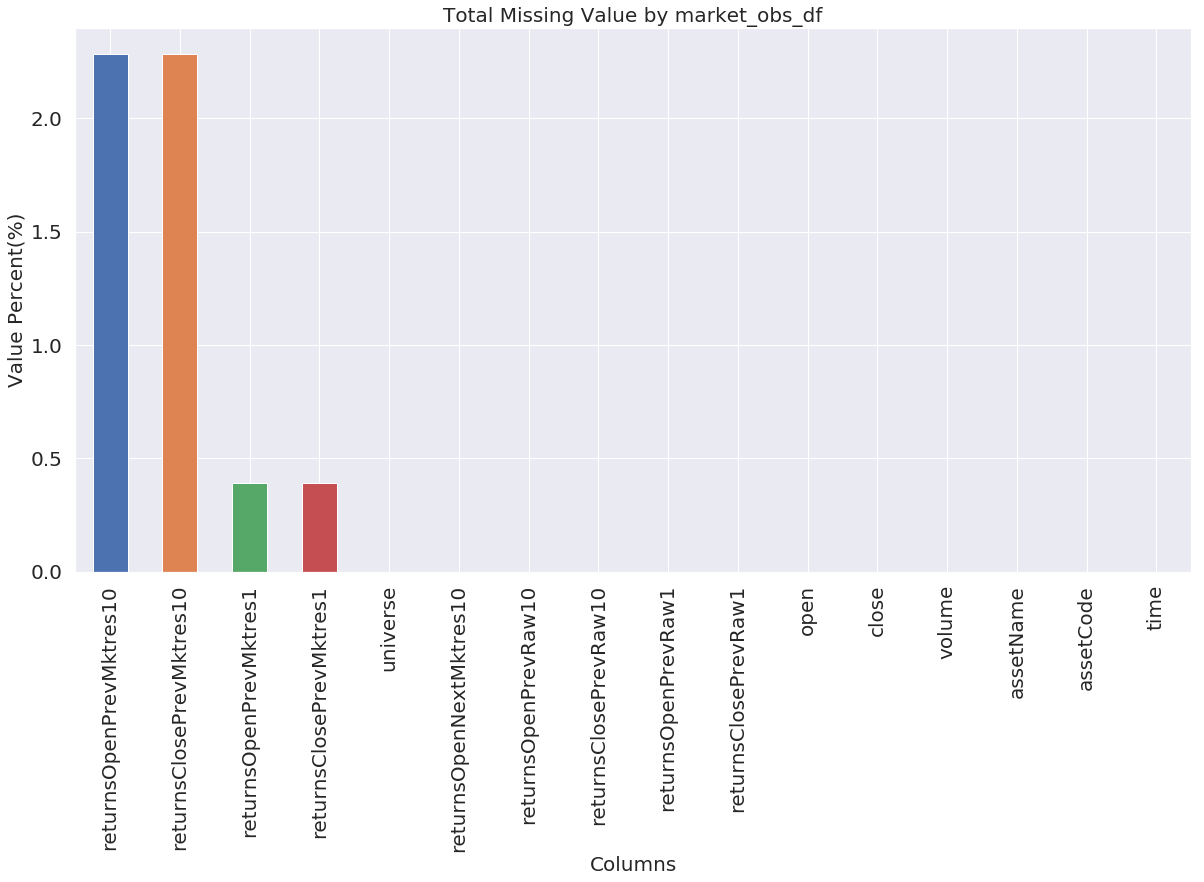

In [13]:
percent = (100 * market_train_df.isnull().sum() / market_train_df.shape[0]).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (20,10), fontsize = 20)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Value Percent(%)", fontsize = 20)
plt.title("Total Missing Value by market_obs_df", fontsize = 20)

Text(0.5,1,'Total Missing Value by market_obs_df')

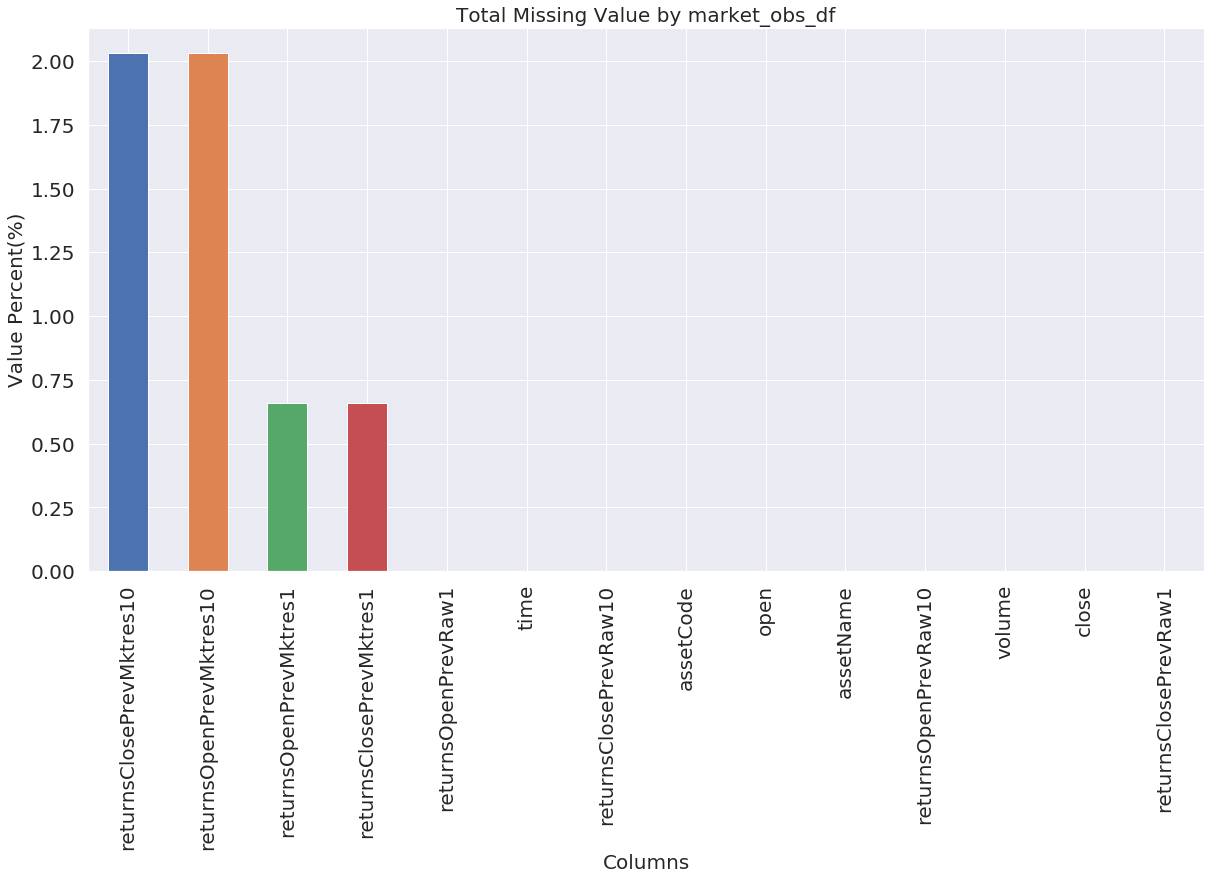

In [14]:
percent1 = (100 * market_obs_df.isnull().sum() / market_obs_df.shape[0]).sort_values(ascending=False)
percent1.plot(kind="bar", figsize = (20,10), fontsize = 20)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Value Percent(%)", fontsize = 20)
plt.title("Total Missing Value by market_obs_df", fontsize = 20)

The types of missing values are the same, but the percentage is slightly different.

market_train_df : { returnsOpenPrevMktres10 : 2.284680 , returnsClosePrevMktres10 : 2.283599, returnsOpenPrevMktres1 : 0.392540 , returnsClosePrevMktres1 : 0.392344 }

market_obs_df : { returnsClosePrevMktres10 : 2.029622, returnsOpenPrevMktres10 : 2.029622, returnsOpenPrevMktres1 : 0.658256, returnsClosePrevMktres1 : 0.658256 }

#### News

In [15]:
news_train_df['headlineTag'].unique()[0:5]

array(['', 'FEATURE', 'PRESS DIGEST', 'RPT', 'TEXT'], dtype=object)

As shown above,, ```''``` is recognized as object. So we have to change these values as missing.

In [16]:
# '' convert to NA
for i in news_train_df.columns.values.tolist():
    # Does NaN means no numbers, can '' be replaced with nan? I do not know this part.
    news_train_df[i] = news_train_df[i].replace('', np.nan)  
news_train_df['headlineTag'].unique()[0:5]
# I think it would be faster if you just replace object and categorical variables(not int,float). How do I fix the code?

array([nan, 'FEATURE', 'PRESS DIGEST', 'RPT', 'TEXT'], dtype=object)

Text(0.5,1,'Total Missing Value by news_train_df')

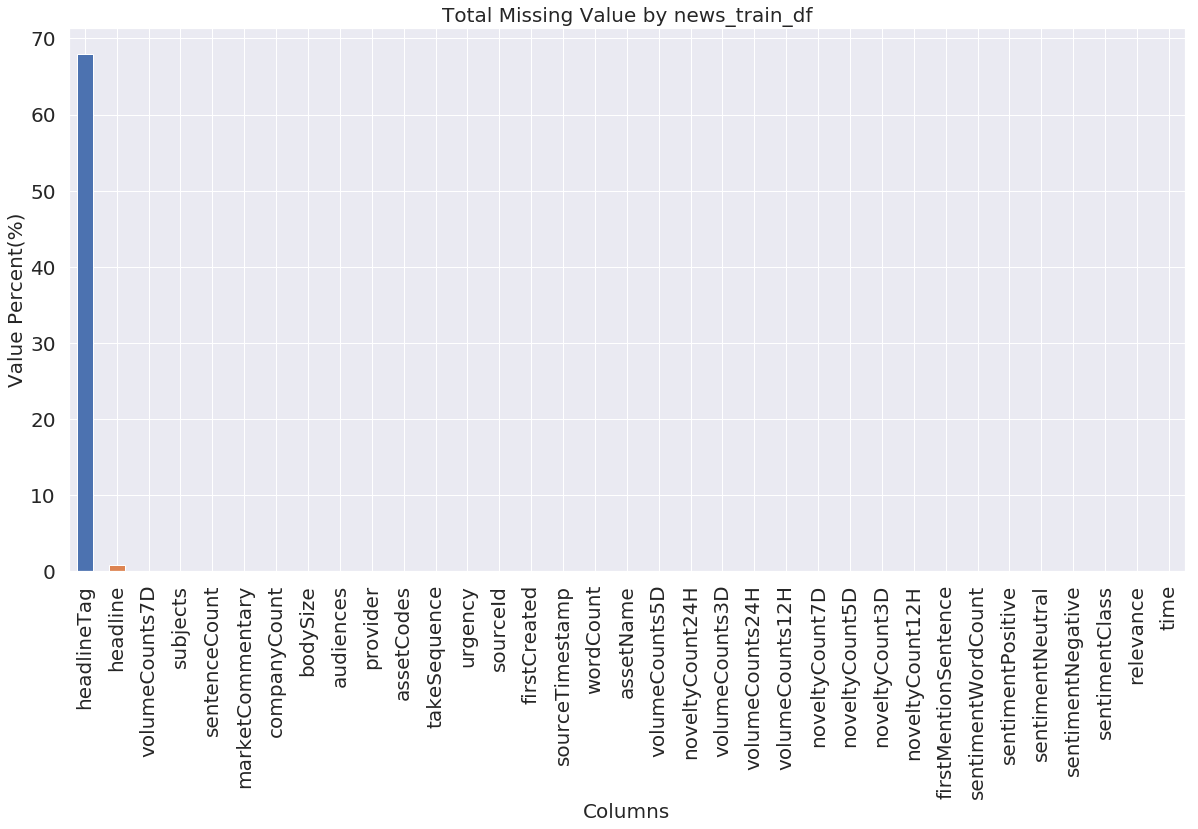

In [17]:
percent = (100 * news_train_df.isnull().sum() / news_train_df.shape[0]).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (20,10), fontsize = 20)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Value Percent(%)", fontsize = 20)
plt.title("Total Missing Value by news_train_df", fontsize = 20)

In [18]:
# '' convert to NA
for i in news_obs_df.columns.values.tolist():
    # Does NaN means no numbers, can '' be replaced with nan? I do not know this part.
    news_obs_df[i] = news_obs_df[i].replace('', np.nan)

Text(0.5,1,'Total Missing Value by news_obs_df')

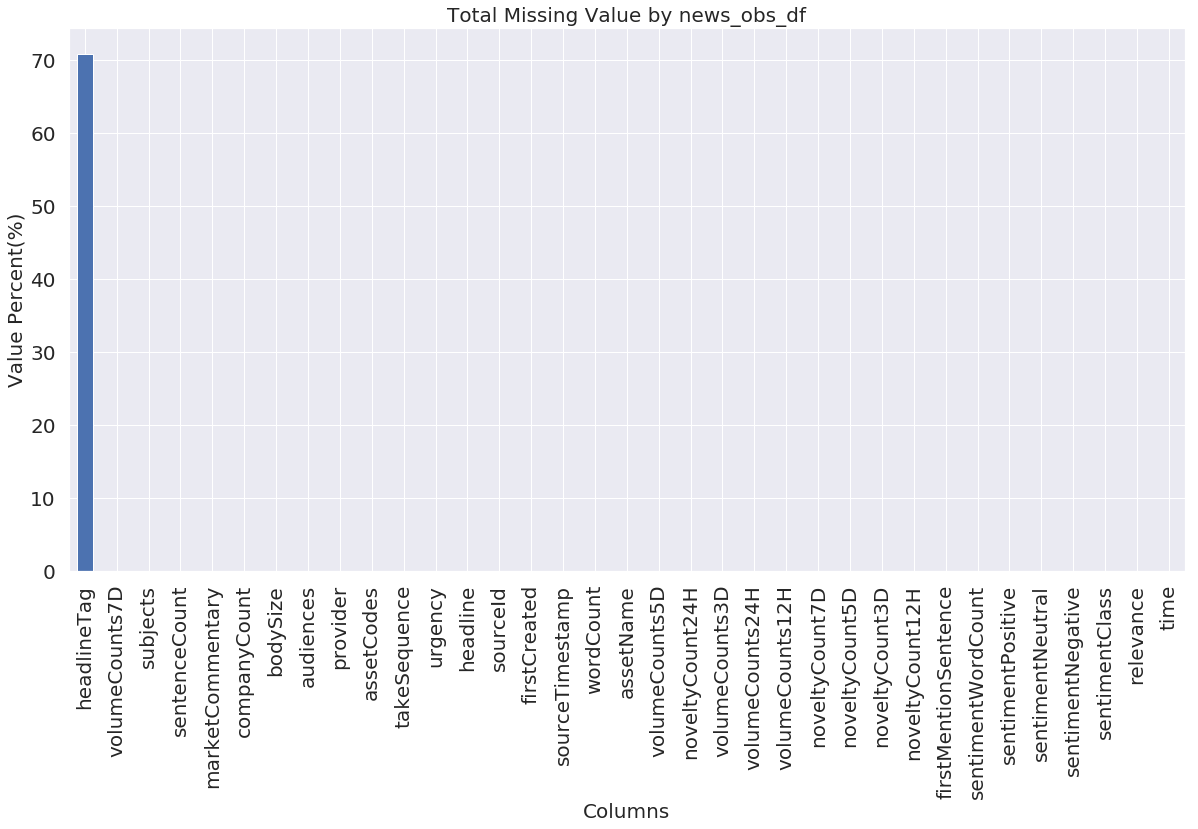

In [19]:
percent1 = (100 * news_obs_df.isnull().sum() / news_obs_df.shape[0]).sort_values(ascending=False)
percent1.plot(kind="bar", figsize = (20,10), fontsize = 20)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Value Percent(%)", fontsize = 20)
plt.title("Total Missing Value by news_obs_df", fontsize = 20)

- headlineTag, both the train and the test are close to 70% missing.
- headline has some missing values, but not the test.

### Number of unique values